## Fitting data to probability density functions (PDF's)

So you have run some simulations and think you saw a pattern? We can't simply make conclusions by eyeballing the histograms plots. No, we have to be rigourous. First, let's explore what are the different types of distributions that often occur, and what are the differences between them.


### Distributions

- Exponentials
- Power law distributions
- Gamma distributions
- ...



## Power law distribution

### x.1 Definition and properties

Different phenomena follow different distributions. A quantity $x$ follows The power law if it is drawn from a probability distribution:

$$
P(x) \propto x^{-\alpha}
$$

Where $\alpha$ is the *exponent* or *scaling parameter*, which typically lies in the range $2 < \alpha < 3$. This defines the slope of the power law in a log-log plot.

Examples of phenomena that are thought to follow power law distributions are things like earth quakes intensities, forest fires and the population size of cities (Clauset et al., 2009). 

When something follows a power law, it doesn't really make sense to calculate the mean or standard deviation like you would do for the normal distribution. Because the power law creates a long tail distribution, meaning: extraordinatory events are possible. Thus, when something follows a power law, we need different metrics to understand its implications.

**Properties**
- power laws have **heavier tails** than exponentials. That is, the right tails of the distributions still contain a great deal of the probability. 
    - these heavy tails make the power law distributions scale-free; all values can be expected to occur because there is no characteristic size or scale (Alstott et al., 2014).
- 

### x.2 How do I know when my data fits a power law?

While we can never be certain that our observations are drawn from a power law distribution, the following are statistical techniques that help us determine whether our observations are in line with the hypothesis that $x$ is drawn from a distribution in the form of the equation above.

**Recipe for analysing power-law distributed data** (Adapted from Clauset et al., 2009)

1. Estimate the parameters $x_{min}$ and $\alpha$ 
2. Calculate the goodness of fit between the data and the power law.
    - If $p > 0.1$: it is plausible that your data follows a power law distribution.
    - Else: it doesn't follow a power law distribution.


Luckily... we have a Python library for that! "[powerlaw](https://github.com/jeffalstott/powerlaw) is a toolbox using the statistical methods developed in (Clauset et al. 2007) and (Klaus et al. 2011) to determine if a probability distribution fits a power law."


### x.3 Intuition: what does it mean when something follows a power law

![](https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2016/05/heavy-tailed-300x178.png)

## Test: does my data fit a power law distribution?

## 1. Run simulation

In [15]:
# === parameter setting ===
sim_params, neuron_params = set_params(J_in=-46.)
# === simulate ===
spike_times_arr, spike_neurons_arr = simulate(patterns, sim_params, neuron_params)
# === transient data ===
transient_spikes, transient_lifetime, transient_size = get_transient_data(spike_times_arr,spike_neurons_arr, sim_params)
# === put in dataframe ===
d = {'transient_spikes':transient_spikes, 'transient_lifetime':transient_lifetime, 'transient_size':transient_size}
df = pd.DataFrame(data=d)

Simulation done! time: 41 seconds


In [17]:
df

,transient_spikes,transient_lifetime,transient_size
0,9235,96.6,1145
1,7721,90.6,1127
2,8780,87.2,1137
3,1522,22.9,891
4,71527,549.6,1191
...,...,...,...
65,4141,50.3,1075
66,10933,91.5,1149
67,3816,43.4,1070
68,17816,158.7,1173


In [109]:
transient_lifetime_lst = df.transient_lifetime.tolist()
transient_size_lst = df.transient_size.tolist()
transient_spikes_lst = df.transient_spikes.tolist()

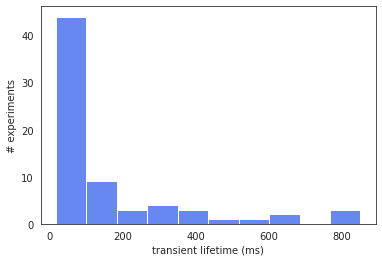

In [73]:
plt.hist(transient_lifetime_lst)
plt.xlabel('transient lifetime (ms)')
plt.ylabel('# experiments');

## 2. Power law

### 2.1 Estimate the parameters $x_{min}$ and $\alpha$

``

### Identify the scaling range 

We have to determine what part of the data to fit. We want to know: from what minimal value $x_{min}$ does the scaling relationship of the power law begins. Clauset et al. (2009) find the optimal starting value by taking the one with the shortest Kolmogorov-Smirnov distance between the data and the fit.

- power laws are undefined for $x=0$ so there must me a minimum value
- I have a list of integers, so my data is discrete 


### Comparing the fit of distributions

- compare the fits of many candidate distributions, and identify which one fits the best. 
Figure 1C visualizes the differences in fit between power law and exponential distribution. The goodness of these distribution fits can be compared with distribution_compare. Again using the blackout data:

In [85]:
results = powerlaw.Fit(transient_lifetime_lst, discrete=True)

print(f'estimate of alpha: {results.power_law.alpha}')
print(f'estimate of x min: {results.power_law.xmin}')

estimate of alpha: 2.024246470478375
estimate of x min: 72.7


Calculating best minimal value for power law fit
/home/nest/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning:invalid value encountered in true_divide
/home/nest/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning:divide by zero encountered in true_divide


### 2.2 Visualise probability density functions

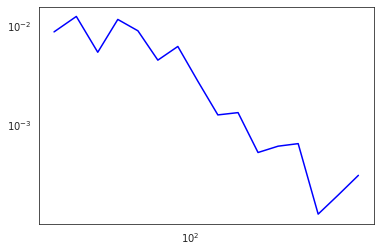

In [107]:
# visualise pdf of the 
powerlaw.plot_pdf(transient_lifetime_lst, color = 'b');

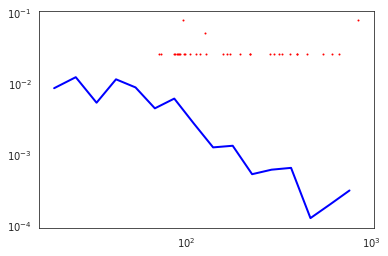

In [93]:
x, y = powerlaw.pdf(transient_lifetime_lst, xmin=72.7, linear_bins=True)
ind = y>0
y = y[ind]
x = x[:-1]
x = x[ind]

plt.scatter(x, y, color='r', s=1)
powerlaw.plot_pdf(transient_lifetime_lst, color='b', linewidth=2);

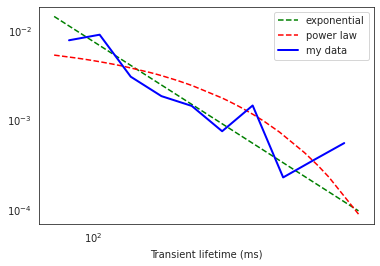

In [103]:
fit.power_law.plot_pdf(linestyle='--', color='g', label='exponential')
fit.exponential.plot_pdf(linestyle='--', color='r', label='power law')
fit.plot_pdf(color='b', linewidth=2, label='my data');
plt.legend();
plt.xlabel('Transient lifetime (ms)');

### 2.3 Compare different distributions

$R$ is the loglikelihood ratio between the two candidate distributions. The likelihood-ratio test assesses the **goodness of fit** of two competing statistical models based on the ratio of their likelihoods.

This number will be positive if the data is more likely in the first distribution, and negative if the data is more likely in the second distribution. The significance value for that direction is $p$. The normalized_ratio option normalizes $R$ by its standard deviation, . The normalized ratio is what is directly used to calculate p.

- If $R > 0$, the data is more likely in the first distribution, and $R < 0$ if the data is more likely in the second distribution.
- $p$ - The significance of the sign of R. If below a critical value (typically .05) the sign of R is taken to be significant. If above the critical value the sign of R is taken to be due to statistical fluctuations.

In [88]:
R, p = results.distribution_compare('power_law', 'exponential', normalized_ratio=True)

print(f'loglikelihood ratio between the two distributions: {R}')
print(f'p value: {p}')

loglikelihood ratio between the two distributions: 0.21021578335694563
p value: 0.8334992614474693


/home/nest/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning:invalid value encountered in true_divide


In [89]:
R, p = results.distribution_compare('power_law', 'lognormal', normalized_ratio=True)

print(f'loglikelihood ratio between the two distributions: {R}')
print(f'p value: {p}')

loglikelihood ratio between the two distributions: -1.1320768766820648
p value: 0.2576021154011796


/home/nest/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning:invalid value encountered in true_divide


## Transient spikes


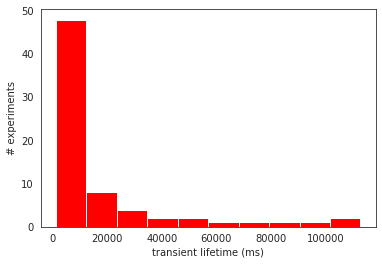

In [111]:
plt.hist(transient_spikes_lst, color='r')
plt.xlabel('transient lifetime (ms)')
plt.ylabel('# experiments');

In [113]:
r = powerlaw.Fit(transient_spikes_lst, discrete=True)

print(f'estimate of alpha: {r.power_law.alpha}')
print(f'estimate of x min: {r.power_law.xmin}')

estimate of alpha: 1.9147999273256406
estimate of x min: 6440.0


Calculating best minimal value for power law fit
/home/nest/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning:invalid value encountered in true_divide
/home/nest/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning:divide by zero encountered in true_divide


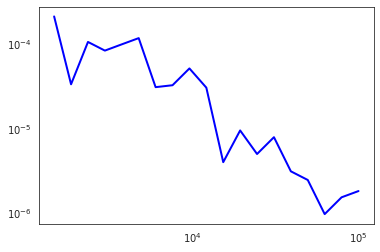

In [114]:
powerlaw.plot_pdf(transient_spikes_lst, color='b', linewidth=2);

## Resources

- [Quanta magazine 'Power laws in real world networks'](https://www.quantamagazine.org/scant-evidence-of-power-laws-found-in-real-world-networks-20180215/)

- [powerlaw toolbox](https://github.com/jeffalstott/powerlaw)

- [scale free](https://blogs.cornell.edu/info2040/2018/09/17/scale-free-networks-are-rare/) + [scale free paper](https://arxiv.org/abs/1801.03400)

## Functions

In [14]:
# nest
import nest
import nest.raster_plot
import nest.voltage_trace
# other
import pandas as pd
import os
import json
import time 
import timeit
import itertools
import numpy as np
from importlib import reload 
from itertools import permutations 
from itertools import combinations 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_palette("coolwarm")
# set the path 
path = 'data/'
# seed 
np.random.seed(0)

import SimulationClass as simu

# update changes made in python script
reload(simu);

H = simu.HelperFuncs()

patterns = []
# make permutations for 8 bit pattern
for perm in H.make_permutations():
    patterns.append(perm)


def set_params(NE=960, NI=240, J_ex=6., J_in=-95., eps=0.1, stim_end=150., sub_fr=0.9, sup_fr=1.1,
              C_m=250.0, g_L=16.7, t_ref=2.0):

    # general simulation parameters
    sim_params = {

        'N_total':1200,
        'NE': 960, # Default: 4/5 are exci neurons, 1/5 are inh neurons
        'NI': 240,
        'J_ex':6.0, # note the big difference between the strength of ex synapses and inh synapses
        'J_in':-95.0,
        'eps':0.1,  # connection probability
        'resolution':0.1,  # temporal resolution of simulation in ms. Kumar2008: 0.1
        'delay':1.5,  # synaptic delay in the network
        'n_threads':8,
        'stim_start':0., # start applying current (dc)
        'stim_end':150., # end applying current (dc)
        'simtime':1000., # simulation time 
        'sub_fr':0.9, # subthreshold current amplitude
        'sup_fr':1.01, # suprathreshold current amplitude
    }
    
    # set neuron parameters
    neuron_params = {
        'C_m': 250.0,
        'E_L': -70.0,
        'E_ex': 0.0,
        'E_in': -80.0,
        'I_e': 0.0,
        'V_reset': -70.0,
        'V_th': -50.0,
        'g_L': 16.7,
        't_ref': 2.0, # Duration of refractory period
        'tau_syn_ex': 0.326, # Rise time of the excitatory synaptic alpha function
        'tau_syn_in': 0.326,
    }
    
    # adapt simulation params
    sim_params['NE'] = NE
    sim_params['NI'] = NI
    sim_params['J_ex'] = J_ex
    sim_params['J_in'] = J_in
    sim_params['eps'] = eps
    sim_params['stim_end'] = stim_end
    sim_params['sub_fr'] = sub_fr
    sim_params['sup_fr'] = sup_fr
    
    # adapt neuron params
    neuron_params['C_m'] = C_m
    neuron_params['g_L'] = g_L
    neuron_params['t_ref'] = t_ref
    
    return sim_params, neuron_params


def simulate(patterns, sim_params, neuron_params):
    '''
    uses the SimulationClass to run a simulation.
    Each simulation consists stimulating the network in 70 different ways, each time stimulating 50% 
    of the neurons with a supra threshold current, 50% with a sub threshold current. 
    
    Returns
    spike_times_arr: array with the exact timings neurons spiked.
    spike_neurons_arr: array with indices of spiking neurons.
    '''
    
    # initialise classes
    udp = simu.UpDownPatterns(sim_params, neuron_params)
    
    # make lists
    spike_times_lst = []
    spike_neurons_lst = []
    multimeters = []
    spikedetectors = []

    # time duration
    start = time.time()

    for i, pattern in enumerate(patterns):
        label = H.list2str(pattern)
        multimet, spikedet, spike_times, spike_neurons = udp.simulate(pattern)

        # convert to python lists 
        spike_times.tolist()
        spike_neurons.tolist()

        spike_times_lst.append(spike_times)
        spike_neurons_lst.append(spike_neurons)
        multimeters.append(multimet)
        spikedetectors.append(spikedet)

    end = time.time()
    print(f'Simulation done! time: {round(end-start)} seconds')

    # convert to np arrays
    spike_times_arr = np.array(spike_times_lst)
    spike_neurons_arr = np.array(spike_neurons_lst)
    
    return spike_times_arr, spike_neurons_arr

def get_transient_data(spike_times_arr, spike_neurons_arr, sim_params):
    '''
    Uses the information from the simulation run to get information about the transient.
    '''
    transient_spikes = []
    transient_lifetime = []
    transient_uniquen = []
    transient_time_arr = []
    
    stim_end = sim_params['stim_end']
    
    for trial in range(len(spike_times_arr)):

        # select data from experiment / trial
        times = spike_times_arr[trial]
        neurons = spike_neurons_arr[trial]

        # === number of spikes ===
        num_trans_spikes = sum(1*(times > stim_end))
        transient_spikes.append(num_trans_spikes)

        # === transient lifetime ===
        transient_time = times[times > stim_end]
        transient_time_arr.append(transient_time)

        if num_trans_spikes == 0:
            transient_lifetime.append(0)
        else:
            t_dur = round(max(transient_time_arr[trial]) - stim_end,2)
            transient_lifetime.append(t_dur)

        # === transient_size ===
        transients = 1*(times > stim_end)
        transient_indices = np.argwhere(transients)
        # take the neurons from these indices
        active_neurons = np.unique(neurons[transient_indices])
        transient_uniquen.append(active_neurons)

    transient_size = [len(i) for i in transient_uniquen]
    
    return transient_spikes, transient_lifetime, transient_size


def get_metrics(transient_size, transient_lifetime):
    
    df = pd.DataFrame({'transient_size':transient_size, 'transient_lifetime':transient_lifetime})
    means = df.mean().tolist()
    maxs = df.max().tolist()
    stds = df.std().tolist()
    
    return means, maxs, stds


def plot(transient_means, transient_maxs, x_axis_name, parameter_range):
    '''
    takes in a list of transient means and max values, name for the x_axis (the parameter value that is being changed) 
    and the range of parameter values used.
    
    Plots the graphs.
    '''
    
    
    # [mean transient size, mean transient lifetime]

    trans_size_means = [i[0] for i in transient_means]
    trans_lifetime_means = [i[1] for i in transient_means]

    trans_size_maxs = [item[0] for item in transient_maxs]
    trans_lifetime_maxs = [item[1] for item in transient_maxs]

    # === Plot ===
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.plot(parameter_range, trans_size_maxs, '--ro', label ='max transient size');
    ax1.plot(parameter_range, trans_size_means, '--bo', label='mean transient size');
    ax1.set_xlabel(x_axis_name)
    ax1.set_ylabel('transient size (neurons)')
    ax1.legend();

    ax2.plot(parameter_range, trans_lifetime_maxs, '--ro', label ='max transient times');
    ax2.plot(parameter_range, trans_lifetime_means, '--bo', label='mean transient times');
    ax2.set_xlabel(x_axis_name);
    ax2.set_ylabel('transient lifetime (ms)')
    ax2.legend();